# Krafthack 7-8. february 2022

In [ ]:
%load_ext autoreload

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm.notebook import tqdm

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.layers import Dense, Input, Activation

import matplotlib.pyplot as plt

from utils.preprocessing import get_timeslots, get_temporal_lookback_features, get_temporal_lookback_df, add_hour_feature, add_seconds_operational

2022-03-08 02:47:13.424534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 02:47:13.424591: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import data

In [2]:
df_train = pd.read_parquet('data/input_dataset-2.parquet')
df_test = pd.read_parquet('data/prediction_input.parquet')

## Clean dataset

In [3]:
# Extract relevant features
cols_keep = list(df_test.columns) + [f'Bolt_{i}_Tensile' for i in range(1,7)]
df_train = df_train[cols_keep]

# Remove rows that contain any missing values
df_train = df_train.dropna()

In [4]:
# Combine both datasets before doing feature engineering
df_full = pd.concat([df_train, df_test], axis=0)

In [5]:
df_full.tail().T

timepoints,1971-02-03 20:16:19,1971-02-03 20:16:20,1971-02-03 20:16:21,1971-02-03 20:16:22,1971-02-03 20:16:23
Unit_4_Power,113.553752,110.520494,107.487618,104.454741,101.421865
Unit_4_Reactive Power,-20.230184,-20.911359,-21.592784,-22.274208,-22.955633
Turbine_Guide Vane Opening,44.871419,43.954699,43.037925,42.121151,41.204377
Turbine_Pressure Drafttube,100.034072,100.034548,100.035024,100.035287,100.034405
Turbine_Pressure Spiral Casing,5419.023758,5419.328873,5419.633988,5420.094237,5421.385963
Turbine_Rotational Speed,106.746818,106.734902,106.722986,106.71107,106.699154
mode,operation,operation,operation,operation,operation
Bolt_1_Tensile,NaN,NaN,NaN,NaN,NaN
Bolt_2_Tensile,NaN,NaN,NaN,NaN,NaN
Bolt_3_Tensile,NaN,NaN,NaN,NaN,NaN


## Feature Engineering
- Log-transform
- Signal-analysis (derivatives, Fourier transform, power, etc)
- Temporal features (day, month, holiday, etc)
- Sequencing
- Onehhot encoding of categorical features

### Add temporal features

In [6]:
df_full = add_hour_feature(df_full)
df_full = add_seconds_operational(df_full)
df_full['time_weekday'] = df_full.index.dayofweek

In [7]:
df_full.tail().T

timepoints,1971-02-03 20:16:19,1971-02-03 20:16:20,1971-02-03 20:16:21,1971-02-03 20:16:22,1971-02-03 20:16:23
Unit_4_Power,113.553752,110.520494,107.487618,104.454741,101.421865
Unit_4_Reactive Power,-20.230184,-20.911359,-21.592784,-22.274208,-22.955633
Turbine_Guide Vane Opening,44.871419,43.954699,43.037925,42.121151,41.204377
Turbine_Pressure Drafttube,100.034072,100.034548,100.035024,100.035287,100.034405
Turbine_Pressure Spiral Casing,5419.023758,5419.328873,5419.633988,5420.094237,5421.385963
Turbine_Rotational Speed,106.746818,106.734902,106.722986,106.71107,106.699154
mode,operation,operation,operation,operation,operation
Bolt_1_Tensile,NaN,NaN,NaN,NaN,NaN
Bolt_2_Tensile,NaN,NaN,NaN,NaN,NaN
Bolt_3_Tensile,NaN,NaN,NaN,NaN,NaN


### Handle categorical feature

In [8]:
def get_mode_as_dummy(df):
    # Make "mode" into dummy variable
    y = pd.get_dummies(df["mode"], prefix="Mode")
    df = df.join(y)
    df.drop("mode", inplace=True, axis=1)
    return df

df_full = get_mode_as_dummy(df_full)

In [9]:
df_full.tail()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,hour,sec_since_last_start,time_weekday,Mode_start,Mode_operation
timepoints,,,,,,,,,,,,,,,,,
1971-02-03 20:16:19,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,NaN,NaN,NaN,NaN,NaN,NaN,20,110668,2,0,1
1971-02-03 20:16:20,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,NaN,NaN,NaN,NaN,NaN,NaN,20,110669,2,0,1
1971-02-03 20:16:21,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,NaN,NaN,NaN,NaN,NaN,NaN,20,110670,2,0,1
1971-02-03 20:16:22,104.454741,-22.274208,42.121151,100.035287,5420.094237,106.711070,NaN,NaN,NaN,NaN,NaN,NaN,20,110671,2,0,1
1971-02-03 20:16:23,101.421865,-22.955633,41.204377,100.034405,5421.385963,106.699154,NaN,NaN,NaN,NaN,NaN,NaN,20,110672,2,0,1


## Get look-back features

In [ ]:
# TODO: Maybe change this for some aggregated features instead

In [ ]:
# columns = [
#     'Unit_4_Power',
#     'Unit_4_Reactive Power',
#     'Turbine_Guide Vane Opening',
#     'Turbine_Pressure Drafttube',
#     'Turbine_Pressure Spiral Casing',
#     'Turbine_Rotational Speed'
#     ]


# df_timeslots_list = get_timeslots(df_full)
# df_full_with_lookback = get_temporal_lookback_df(df_timeslots_list, cols=columns, window_size=30, steps=5)

## Split data into train-validate-test

In [13]:
# df_train_new = df_full_with_lookback[df_train.index[0]:df_train.index[-1]].dropna()
# df_test_new  = df_full_with_lookback[df_test.index[0]:df_test.index[-1]]

df_train_new = df_full[df_train.index[0]:df_train.index[-1]].dropna()
df_test_new  = df_full[df_test.index[0]:df_test.index[-1]]

In [14]:
df_test_new['1971-01-31 06:47:00':].head(5)

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,hour,sec_since_last_start,time_weekday,Mode_start,Mode_operation
timepoints,,,,,,,,,,,,,,,,,
1971-01-31 06:47:04,311.552596,6.853044,94.678123,101.542349,5294.068900,108.029707,NaN,NaN,NaN,NaN,NaN,NaN,6,58980,6,0,1
1971-01-31 06:47:05,311.568429,6.504612,94.678123,101.542148,5293.887937,108.029696,NaN,NaN,NaN,NaN,NaN,NaN,6,58981,6,0,1
1971-01-31 06:47:06,311.584261,6.156180,94.678123,101.542214,5293.666748,108.029685,NaN,NaN,NaN,NaN,NaN,NaN,6,58982,6,0,1
1971-01-31 06:47:07,311.600094,5.807748,94.678123,101.542279,5293.445559,108.029674,NaN,NaN,NaN,NaN,NaN,NaN,6,58983,6,0,1
1971-01-31 06:47:08,311.615927,5.459316,94.678123,101.542345,5293.224370,108.029664,NaN,NaN,NaN,NaN,NaN,NaN,6,58984,6,0,1


In [15]:
df_train_new.tail(2)

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,hour,sec_since_last_start,time_weekday,Mode_start,Mode_operation
timepoints,,,,,,,,,,,,,,,,,
1971-01-25 11:06:47,308.807131,4.842597,94.435677,158.068966,5280.040144,108.057479,1637.357141,1504.531582,1701.662201,1606.245665,1640.685782,1689.995135,11,19734,0,0,1
1971-01-25 11:06:48,308.837499,5.212264,94.439014,158.115137,5279.835631,108.057473,1637.344985,1504.525065,1701.658131,1606.286286,1640.698392,1690.004759,11,19735,0,0,1


In [16]:
df_test_new.head(2)

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,hour,sec_since_last_start,time_weekday,Mode_start,Mode_operation
timepoints,,,,,,,,,,,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,NaN,NaN,NaN,NaN,NaN,NaN,11,19736,0,0,1
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,NaN,NaN,NaN,NaN,NaN,NaN,11,19737,0,0,1


In [17]:
print(f"df_train: {df_train.shape}")
print(f"df_train_new: {df_train_new.shape}")
print(f"df_test: {df_test.shape}")
print(f"df_test_new: {df_test_new.shape}")

df_train: (1750000, 13)
df_train_new: (1750000, 17)
df_test: (226364, 7)
df_test_new: (226364, 17)


In [18]:
PCT_SPLIT = 0.7
labels = [f"Bolt_{i}_Tensile" for i in range(1,7)]

X_train_full = df_train_new.drop(labels, axis=1)  # Official test set
y_train_full = df_train_new[labels]  # Official test labels

X_test_full = df_test_new.drop(labels, axis=1)  # Official test set

X_train_train = X_train_full[:int(PCT_SPLIT*len(X_train_full))]  # Private test set
y_train_train = y_train_full[:int(PCT_SPLIT*len(y_train_full))]  # Private test labels
X_train_val = X_train_full[int(PCT_SPLIT*len(X_train_full)):]  # Private validation set
y_train_val = y_train_full[int(PCT_SPLIT*len(y_train_full)):]  # Private validation labels


In [19]:
print(f"X_train_full:   {X_train_full.shape}")
print(f"y_train_full:   {y_train_full.shape}")
print(f"X_test_full:    {X_test_full.shape}")

print()

print(f"X_train_train:  {X_train_train.shape}")
print(f"y_train_train:  {y_train_train.shape}")

print()

print(f"y_train_val:    {y_train_val.shape}")
print(f"X_train_val:    {X_train_val.shape}")

X_train_full:   (1750000, 11)
y_train_full:   (1750000, 6)
X_test_full:    (226364, 11)

X_train_train:  (1225000, 11)
y_train_train:  (1225000, 6)

y_train_val:    (525000, 6)
X_train_val:    (525000, 11)


### Save datasets

In [20]:
X_train_full.to_pickle('data/X_train_full.pkl')
y_train_full.to_pickle('data/y_train_full.pkl')

X_test_full.to_pickle('data/X_test_full.pkl')

X_train_train.to_pickle('data/X_train_train.pkl')
y_train_train.to_pickle('data/y_train_train.pkl')

X_train_val.to_pickle('data/X_train_val.pkl')
y_train_val.to_pickle('data/y_train_val.pkl')

### Load datasets

In [21]:
X_train_full = pd.read_pickle('data/X_train_full.pkl')
y_train_full = pd.read_pickle('data/y_train_full.pkl')

X_test_full = pd.read_pickle('data/X_test_full.pkl')

X_train_train = pd.read_pickle('data/X_train_train.pkl')
y_train_train = pd.read_pickle('data/y_train_train.pkl')

X_train_val = pd.read_pickle('data/X_train_val.pkl')
y_train_val = pd.read_pickle('data/y_train_val.pkl')

labels = [f"Bolt_{i}_Tensile" for i in range(1,7)]

## Scaling


In [22]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train_train),
    index = X_train_train.index,
    columns = X_train_train.columns
    )
X_train_val_scaled = pd.DataFrame(
    scaler_X.transform(X_train_val),
    index = X_train_val.index,
    columns = X_train_val.columns
    )
y_train_scaled = pd.DataFrame(
    scaler_y.fit_transform(y_train_train),
    index = y_train_train.index,
    columns = y_train_train.columns
    )
y_train_val_scaled = pd.DataFrame(
    scaler_y.transform(y_train_val),
    index = y_train_val.index,
    columns = y_train_val.columns
    )

## Train Model

In [53]:
models = {}
model_types = {}
model_configs = {}
model_fit_config = {}

def train_model(models, model_type, model_config, model_fit_config, model_name, labels, X, y):
    models[model_name] = {label: model_type(**model_config) for label in labels}

    for label in tqdm(labels):
        models[model_name][label].fit(X, y[label], **model_fit_config)

### Linear Regression

In [54]:
MODEL_NAME = 'linreg'
model_types[MODEL_NAME] = LinearRegression
model_configs[MODEL_NAME] = {}
model_fit_config[MODEL_NAME] = {}

train_model(
    models,
    model_type=model_types[MODEL_NAME],
    model_config=model_configs[MODEL_NAME],
    model_fit_config=model_fit_config[MODEL_NAME],
    model_name=MODEL_NAME,
    labels=labels,
    X=X_train_scaled,
    y=y_train_scaled
)

  0%|          | 0/6 [00:00<?, ?it/s]

### XGBoost

In [57]:
MODEL_NAME = 'xgboost'
model_types[MODEL_NAME]=XGBRegressor
model_configs[MODEL_NAME] = dict(
    booster="gbtree",
    learning_rate=0.2,
    gamma=0.1,
    max_depth=6,
    eval_metric="mae")
model_fit_config[MODEL_NAME] = {}

train_model(
    models,
    model_type=model_types[MODEL_NAME],
    model_config=model_configs[MODEL_NAME],
    model_fit_config=model_fit_config[MODEL_NAME],
    model_name=MODEL_NAME,
    labels=labels,
    X=X_train_scaled,
    y=y_train_scaled
)

### CatBoost

In [58]:
MODEL_NAME = 'catboost'
model_types[MODEL_NAME]=CatBoostRegressor
model_configs[MODEL_NAME] = dict(iterations=400)
model_fit_config[MODEL_NAME] = dict(verbose=False)


train_model(
    models,
    model_type=model_types[MODEL_NAME],
    model_config=model_configs[MODEL_NAME],
    model_fit_config=model_fit_config[MODEL_NAME],
    model_name=MODEL_NAME,
    labels=labels,
    X=X_train_scaled,
    y=y_train_scaled
)

### Multilayer perceptron

## Cross Validation
- [Special methods for time-series data](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

## Hyperparameter tuning
- [Sklearn](https://scikit-learn.org/stable/modules/grid_search.html)
- [Nevergrad](https://facebookresearch.github.io/nevergrad/)
- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

## Predict

In [48]:
# labels = [f"Bolt_{i}_Tensile" for i in range(1,7)]
y_preds_scaled = {}
y_preds = {}


for model_name, model in tqdm(models.items(), total=len(models)):
    # For each model type
    y_preds[model_name] = {}
    for label in tqdm(labels):
        # For each sub-model specialized for a unique label column
        y_preds[model_name][label] = model[label].predict(X_train_val_scaled)

    y_preds_scaled[model_name] = pd.DataFrame(y_preds[model_name])
    y_preds[model_name] = pd.DataFrame(scaler_y.inverse_transform(y_preds_scaled[model_name].to_numpy()),
                                       index=y_preds_scaled[model_name].index,
                                       columns=y_preds_scaled[model_name].columns
                                       )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

## Plot predictions vs truth

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

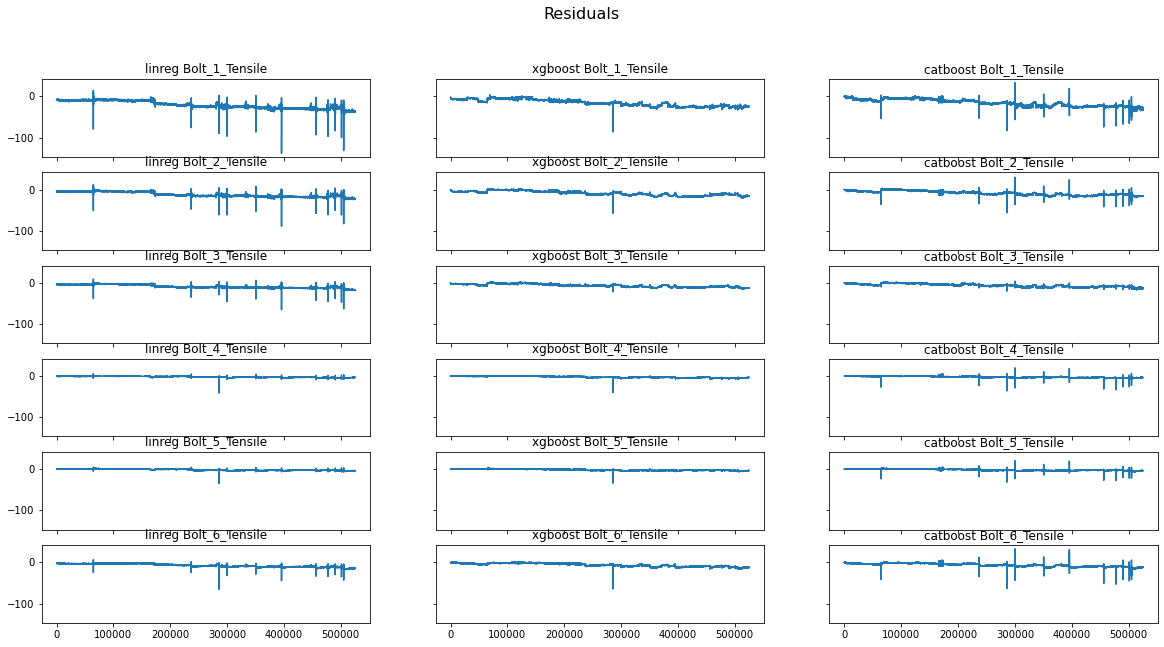

In [49]:
fig, axs = plt.subplots(6, len(y_preds), sharey=True, sharex=True, figsize=(20,10))
fig.suptitle('Residuals', fontsize=16)
for j, (model_name, y_hats) in tqdm(enumerate(y_preds.items()), total=len(y_preds)):
    for i, col in tqdm(enumerate(y_hats.columns), total=y_hats.shape[1]):
        axs[i,j].plot(y_hats[col] - y_train_val[col].to_numpy())
        axs[i,j].set_title(f"{model_name} {col}")


## Scoring
- Good metrics for temporal data?
- Depends on competition metric

In [50]:
score = {}

for model_name, model in y_preds.items():
    score[model_name] = {}
    
    for label in labels:
        score[model_name][label] = mape(y_train_val[label], y_preds[model_name][label])

scores = pd.DataFrame(score).T
scores.rename({x: f'MAPE {x}' for x in scores.columns}, axis=1)
scores['Avg MAPE'] = scores.mean(axis=1)
scores = scores.sort_values(by='Avg MAPE', ascending=True)
BEST_MODEL = scores.index[0]

scores

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Avg MAPE
catboost,0.009426,0.005615,0.003643,0.001463,0.001155,0.003782,0.004181
xgboost,0.009485,0.005821,0.003843,0.001470,0.001116,0.003628,0.004227
linreg,0.012619,0.007972,0.005208,0.001282,0.001062,0.004401,0.005424


## Bonus: Using the output of the first model as input to a second model

## Model explanation
- Explainable model ([interpretml](https://github.com/interpretml/interpret))
- Certainty score
- [LIME](https://github.com/marcotcr/lime)
- [SHAP](https://github.com/slundberg/shap)

## Prepare competition submission

### Train model on whole training seti

In [59]:
# Scale full training set
scaler_X_full = StandardScaler()
scaler_y_full = StandardScaler()

X_train_full_scaled = scaler_X.fit_transform(X_train_full)
X_test_full_scaled = scaler_X.transform(X_test_full)
y_train_full_scaled = scaler_y_full.fit_transform(y_train_full)

# Train on full training set
train_model(
    models,
    model_type=model_types[MODEL_NAME],
    model_config=model_configs[BEST_MODEL],
    model_fit_config=model_fit_config[BEST_MODEL],
    model_name=MODEL_NAME,
    labels=labels,
    X=X_train_scaled,
    y=y_train_scaled
)

  0%|          | 0/6 [00:00<?, ?it/s]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

### Make predictions

In [60]:
y_final_preds_scaled = {}
y_final_preds = {}

for label in tqdm(labels):
    # For each sub-model specialized for a unique label column
    y_final_preds_scaled[label] = models[BEST_MODEL][label].predict(X_test_full_scaled)

y_final_preds_scaled = pd.DataFrame(y_final_preds_scaled)
y_final_preds = pd.DataFrame(scaler_y.inverse_transform(y_final_preds_scaled.to_numpy()),
                                    index=y_final_preds_scaled.index,
                                    columns=y_final_preds_scaled.columns
                                    )

  0%|          | 0/6 [00:00<?, ?it/s]

### Export CSV

In [61]:
y_final_preds.index = X_test_full.index
y_final_preds.to_csv('submission.csv')

y_final_preds.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,
1971-01-25 11:06:49,1611.432071,1489.353863,1687.790078,1602.813289,1637.406897,1678.623775
1971-01-25 11:06:50,1611.408544,1489.340912,1687.727572,1602.810750,1637.406897,1678.607766
1971-01-25 11:06:51,1611.280835,1489.241712,1687.724589,1602.968337,1637.406897,1678.597920
1971-01-25 11:06:52,1611.289163,1489.338891,1687.720769,1602.943407,1637.405593,1678.614299
1971-01-25 11:06:53,1610.882509,1489.375619,1687.720769,1602.911291,1637.418492,1678.614299


## Deployment
- Pipeline for deploying model
- Build API using FastAPI or Flask
- Host model in e.g. Azure